In [1]:
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
from sklearn.cluster import KMeans

In [45]:
def getPartialRMSD(moving, ref, phi):
    """

    :param moving:
    :param ref:
    :param phi:
    :return: rmsd, minimal_movement_indices
    """

    # translate
    moved = moving - (centroid(moving) - centroid(ref))
    # calculate rotational matrix
    rot = quaternion_rotate(moved, ref)
    # calculate aligned moved position
    moved = np.dot(moved, rot)

    _msd = msd(moved, ref)
    core_indices = np.argsort(_msd)[0:int(len(moved) * phi)]

    while True:
        rot = quaternion_rotate(moved[core_indices], ref[core_indices])
        moved = np.dot(moved, rot)
        _msd = msd(moved, ref)
        new_core_indices = np.argsort(_msd)[0:int(len(moved) * phi)]
        if np.array_equal(new_core_indices, core_indices):
            # Check if converge
            
            break
        else:
            core_indices = new_core_indices

    return rmsd(moved[core_indices], ref[core_indices]), core_indices

def clusterCore(moving, ref):
    """
    Experimental function to cluster parts to identify core region automatically.
    :return:
    """
    moved = moving - (centroid(moving) - centroid(ref))
    # calculate rotational matrix
    rot = quaternion_rotate(moved, ref)
    # calculate aligned moved position
    moved = np.dot(moved, rot)
    _msd = msd(moved, ref)
    # Plot histogram of msd

    kmean = KMeans(n_clusters=2, random_state=0)
    kmean.fit(np.stack([1/(1+ np.square(_msd)), np.zeros(len(_msd))]).transpose())
    core_indices = kmean.labels_ == 1
    i = 0
    while i < 300:
        rot = quaternion_rotate(moved[core_indices], ref[core_indices])
        moved = np.dot(moved, rot)
        _msd = msd(moved, ref)
        normalized_msd = 1/(1+ np.square(_msd))
        kmean = KMeans(n_clusters=2,random_state=0)
        kmean.fit(np.stack([normalized_msd, np.zeros(len(_msd))]).transpose())
        new_core_indices = np.where(kmean.labels_ == 1)[0]
        new_core_indices = kmean.labels_ == 1 if np.average(normalized_msd[kmean.labels_ == 1]) > np.average(normalized_msd[kmean.labels_ == 0]) else kmean.labels_ == 0
#         plt.hist(normalized_msd)
#         plt.hist(normalized_msd[new_core_indices])
        print(new_core_indices.sum() / len(_msd))
        if np.array_equal(new_core_indices, core_indices):
#             print(len(new_core_indices), len(_msd))
#             plt.scatter(_msd, kmean.labels_)
#             plt.hist(_msd[np.where(kmean.labels_ == 1)[0]])
            
            break
        else:
            core_indices = new_core_indices
            i += 1

        # kmean.fit(np.stack([_msd,np.zeros(len(_msd))]).transpose())
        # print(kmean.labels_)
        # 
        # print(_msd[kmean.labels_ == 1])
        # 
        # # 
        


def quaternion_transform(r):
    """
    Get optimal rotation
    note: translation will be zero when the centroids of each molecule are the
    same
    """
    Wt_r = makeW(*r).T
    Q_r = makeQ(*r)
    rot = Wt_r.dot(Q_r)[:3, :3]
    return rot


def makeW(r1, r2, r3, r4=0):
    """
    matrix involved in quaternion rotation
    """
    W = np.asarray([
        [r4, r3, -r2, r1],
        [-r3, r4, r1, r2],
        [r2, -r1, r4, r3],
        [-r1, -r2, -r3, r4]])
    return W


def makeQ(r1, r2, r3, r4=0):
    """
    matrix involved in quaternion rotation
    """
    Q = np.asarray([
        [r4, -r3, r2, r1],
        [r3, r4, -r1, r2],
        [-r2, r1, r4, r3],
        [-r1, -r2, -r3, r4]])
    return Q


def quaternion_rotate(X, Y):
    """
    Calculate the rotation

    Parameters
    ----------
    X : ndarray
        (N,D) matrix, where N is points and D is dimension.
    Y:  ndarray
        (N,D) matrix, where N is points and D is dimension.

    Returns
    -------
    rot : matrix
        Rotation matrix (D,D)
    """
    N = X.shape[0]
    W = np.asarray([makeW(*Y[k]) for k in range(N)])
    Q = np.asarray([makeQ(*X[k]) for k in range(N)])
    Qt_dot_W = np.asarray([np.dot(Q[k].T, W[k]) for k in range(N)])
    W_minus_Q = np.asarray([W[k] - Q[k] for k in range(N)])
    A = np.sum(Qt_dot_W, axis=0)
    eigen = np.linalg.eigh(A)
    r = eigen[1][:, eigen[0].argmax()]
    rot = quaternion_transform(r)
    return rot


def centroid(X):
    """
    Calculate the centroid from a vectorset X.

    https://en.wikipedia.org/wiki/Centroid
    Centroid is the mean position of all the points in all of the coordinate
    directions.

    C = sum(X)/len(X)

    Parameters
    ----------
    X : array
        (N,D) matrix, where N is points and D is dimension.

    Returns
    -------
    C : float
        centeroid

    """
    C = np.mean(X,axis=0)
    return C


def rmsd(V, W):
    """
    Calculate Root-mean-square deviation from two sets of vectors V and W.

    Parameters
    ----------
    V : array
        (N,D) matrix, where N is points and D is dimension.
    W : array
        (N,D) matrix, where N is points and D is dimension.

    Returns
    -------
    rmsd : float
        Root-mean-square deviation

    """
    D = len(V[0])
    N = len(V)
    rmsd = 0.0
    for v, w in zip(V, W):
        rmsd += sum([(v[i] - w[i]) ** 2.0 for i in range(D)])
    return np.sqrt(rmsd / N)


def msd(V, W) -> np.ndarray:
    """
    Calculate mean-square deviation from two sets of vectors V and W.

    Parameters
    ----------
    V : ndarray
        (N,D) matrix, where N is points and D is dimension.
    W : ndarray
        (N,D) matrix, where N is points and D is dimension.

    Returns
    -------
    msd : float
        mean-square deviation

    """
    return np.sqrt(np.sum(np.square(V - W), axis=1))


(894, 3) (894, 3)
0.144295302013
0.337807606264
0.365771812081
0.345637583893
0.341163310962
0.334451901566
0.318791946309
0.319910514541
0.325503355705
0.32774049217
0.32774049217


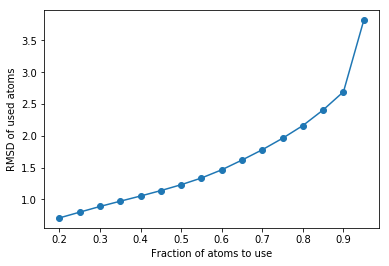

In [48]:
conf1 = md.load('1IG9.pdb')
conf2 = md.load('1IH7.pdb')
coord1 = conf1.atom_slice(conf1.top.select("name CA")).xyz[0] * 10 
coord2 = conf2.atom_slice(conf2.top.select("name CA")).xyz[0] * 10 

print(coord1.shape, coord2.shape)
        

clusterCore(coord1, coord2)

phis = []
partial_rmsds = []

for phi in np.arange(0.2, 1.0, 0.05):
    partial_rmsd, align_indices = getPartialRMSD(moving=coord1, ref=coord2, phi=phi)
    phis.append(phi)
    partial_rmsds.append(partial_rmsd)

plt.plot(phis, partial_rmsds, linestyle='-', marker='o')
plt.xlabel("Fraction of atoms to use")
plt.ylabel("RMSD of used atoms")
plt.show()


(99, 3) (99, 3)
0.545454545455
0.787878787879
0.787878787879
0.777777777778
0.747474747475
0.747474747475


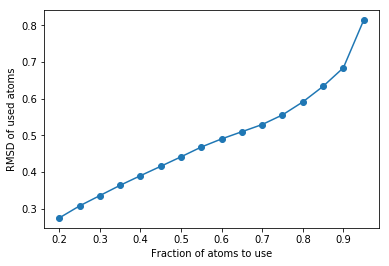

In [49]:
conf1 = md.load('1KZK.pdb')
conf2 = md.load('1HHP.pdb')
coord1 = conf1.atom_slice(conf1.top.select("name CA")).xyz[0] * 10 
coord2 = conf2.atom_slice(conf2.top.select("name CA")).xyz[0] * 10 

print(coord1.shape, coord2.shape)
        

clusterCore(coord1, coord2)



phis = []
partial_rmsds = []

for phi in np.arange(0.2, 1.0, 0.05):
    partial_rmsd, align_indices = getPartialRMSD(moving=coord1, ref=coord2, phi=phi)
    phis.append(phi)
    partial_rmsds.append(partial_rmsd)

plt.plot(phis, partial_rmsds, linestyle='-', marker='o')
plt.xlabel("Fraction of atoms to use")
plt.ylabel("RMSD of used atoms")
plt.show()

array([ 2.82909989,  0.61559999, -0.34209999], dtype=float32)